In [1]:
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import VotingRegressor
import numpy as np
import pandas as pd
import tensorflow as tf

from imbd.trainers import ModelTrainer
from imbd.data import DataLoader
from imbd.preprocessors import DataPreprocessor
from imbd.models import KerasModel

In [2]:
loader = DataLoader()
prepro = DataPreprocessor()


In [3]:
    param_grid = {
        "prepro__variance_selector__threshold": [0.0, 0.01, 0.05],
        # "model__epochs": [10, 20, 100],
        # "model__dropout_rate": [0.3, 0.1],
        # "model__estimator__n_estimators": [100],
        # "model__estimator__max_depth": [5, 10],
        # "model__estimator__alpha": [0, 0.1, 0.01],
        # "model__estimator__lambda": [1, 0.5, 0.1],
        # "model__estimator__subsample": [1, 0.5],
        # "model__estimator__gamma": [0, 2, 10],
    }

In [4]:
# initialization
loader = DataLoader()
preprocessor = DataPreprocessor()
df = loader.build()

# get feature & label
train_features = df.drop(loader.labels, axis=1)
train_labels = df[loader.labels]

In [5]:
# base_model = MultiOutputRegressor(XGBRegressor())
base_model = MultiOutputRegressor(VotingRegressor([('xgb', XGBRegressor()), ('xgb_rf', XGBRFRegressor())]))

# base_nn_model = KerasRegressor(build_fn=classifier, epochs=100)
base_nn_model = KerasModel()

In [6]:
# build pipeline
steps = [('prepro', preprocessor), ('model', base_model)]
pipe = Pipeline(steps=steps)

In [7]:
pipe.get_params()['prepro'].get_params()

{'drop_na_by_threshold': NADropper(),
 'quantization': <imbd.preprocessors.QuantizationTransformer at 0x13bbb6f28>,
 'shift_processor': <imbd.preprocessors.ShiftProcessor at 0x13bbb6ef0>,
 'fill_na': <imbd.preprocessors.FillNATransformer at 0x13bbb6f60>,
 'nn_embedder': <imbd.preprocessors.NNFeatureEmbedder at 0x13bbb6cc0>,
 'variance_selector': VarianceFeatureSelector(),
 'outlier_detection': <imbd.preprocessors.OutlierDetector at 0x13bbb6cf8>,
 'drop_na_by_threshold__na_threshold': 10,
 'variance_selector__threshold': 0.0}

In [8]:
# training
trainer = ModelTrainer(pipe=pipe, param_grid=param_grid, verbose=2)
fitted = trainer.fit(train_features, train_labels)

'Input_C_068_x' 'Input_C_068_y'
 'Input_C_069_x' 'Input_C_069_y' 'Input_C_070_x' 'Input_C_070_y'
 'Input_C_071_x' 'Input_C_071_y' 'Input_C_072_x' 'Input_C_072_y'
 'Input_C_073_x' 'Input_C_073_y' 'Input_C_074_x' 'Input_C_074_y'
 'Input_C_075_x' 'Input_C_075_y' 'Input_C_076_x' 'Input_C_076_y'
 'Input_C_077_x' 'Input_C_077_y' 'Input_C_078_x' 'Input_C_078_y'
 'Input_C_079_x' 'Input_C_079_y' 'Input_C_080_x' 'Input_C_080_y'
 'Input_C_081_x' 'Input_C_081_y' 'Input_C_082_x' 'Input_C_082_y' 'outlier']
Columns remained: ['index' 'Input_A2_020' 'Input_A3_020' 'Input_A4_020' 'Input_A5_005'
 'Input_A5_020' 'Input_A6_004' 'Input_A6_020' 'Input_C_001' 'Input_C_008'
 'Input_C_061' 'Input_C_062' 'Input_C_135' 'Input_C_136' 'Input_C_137'
 'Output_A1' 'Output_A2' 'Output_A3' 'Output_A4' 'Output_A5' 'Output_A6'
 'Input_C_015_x' 'Input_C_015_y' 'Input_C_016_x' 'Input_C_016_y'
 'Input_C_017_x' 'Input_C_017_y' 'Input_C_018_x' 'Input_C_018_y'
 'Input_C_019_x' 'Input_C_019_y' 'Input_C_020_x' 'Input_C_020_y'
 '

In [9]:
fitted.best_score_

-0.14129791672138461

In [10]:
pd.DataFrame(fitted.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_prepro__variance_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,10.620434,1.657889,0.378594,0.009450,0,{'prepro__variance_selector__threshold': 0.0},-0.150818,-0.165364,-0.107712,-0.141298,0.024480,1,-0.016729,-0.014814,-0.020431,-0.017325,0.002332
1,6.368100,1.667331,0.361720,0.009627,0.01,{'prepro__variance_selector__threshold': 0.01},-0.156873,-0.164450,-0.118555,-0.146626,0.020089,2,-0.019635,-0.016463,-0.020958,-0.019019,0.001886
2,4.950130,1.477705,0.312985,0.003063,0.05,{'prepro__variance_selector__threshold': 0.05},-0.156873,-0.164982,-0.119930,-0.147261,0.019608,3,-0.019635,-0.016503,-0.021031,-0.019056,0.001893


In [11]:
pred = fitted.predict(train_features)
pred = pd.DataFrame(pred, columns=train_labels.columns)

res = np.abs(pred - train_labels)
res = res.rename(mapper=lambda x: x + "_diff", axis=1)
res['mean'] = np.mean(res, axis=1)
res['label'] = pd.cut(res['mean'].astype('category'), bins=3, labels=['0', '1', '2'])
res['label'] = res['label'].astype(int)

Columns remained: ['index' 'Input_A1_001' 'Input_A1_002' 'Input_A1_003' 'Input_A1_004'
 'Input_A1_005' 'Input_A1_006' 'Input_A1_007' 'Input_A1_008'
 'Input_A1_009' 'Input_A1_011' 'Input_A1_012' 'Input_A1_013'
 'Input_A1_014' 'Input_A1_015' 'Input_A1_016' 'Input_A1_017'
 'Input_A1_018' 'Input_A1_019' 'Input_A1_021' 'Input_A1_022'
 'Input_A1_023' 'Input_A1_024' 'Input_A2_001' 'Input_A2_002'
 'Input_A2_003' 'Input_A2_004' 'Input_A2_005' 'Input_A2_006'
 'Input_A2_007' 'Input_A2_009' 'Input_A2_011' 'Input_A2_012'
 'Input_A2_013' 'Input_A2_014' 'Input_A2_015' 'Input_A2_018'
 'Input_A2_019' 'Input_A2_020' 'Input_A2_021' 'Input_A2_022'
 'Input_A2_023' 'Input_A3_001' 'Input_A3_002' 'Input_A3_003'
 'Input_A3_004' 'Input_A3_005' 'Input_A3_006' 'Input_A3_007'
 'Input_A3_008' 'Input_A3_009' 'Input_A3_010' 'Input_A3_011'
 'Input_A3_012' 'Input_A3_014' 'Input_A3_019' 'Input_A3_020'
 'Input_A3_021' 'Input_A3_022' 'Input_A3_023' 'Input_A3_024'
 'Input_A4_001' 'Input_A4_002' 'Input_A4_003' 'Input_A4_004

In [12]:
res

,Input_A6_024_diff,Input_A3_016_diff,Input_C_013_diff,Input_A2_016_diff,Input_A3_017_diff,Input_C_050_diff,Input_A6_001_diff,Input_C_096_diff,Input_A3_018_diff,Input_A6_019_diff,...,Input_A3_015_diff,Input_C_046_diff,Input_C_049_diff,Input_A2_024_diff,Input_C_058_diff,Input_C_057_diff,Input_A3_013_diff,Input_A2_017_diff,mean,label
0,0.000259,0.002440,0.000202,0.000913,0.000710,0.000850,0.000360,0.003140,0.003148,0.003533,...,0.007730,0.000065,0.000111,0.000050,0.000806,0.000595,0.000117,0.002489,0.008042,0
1,0.000051,0.000601,0.000533,0.001017,0.002902,0.000298,0.000006,0.004368,0.002278,0.000019,...,0.005944,0.000104,0.000038,0.000055,0.000583,0.000663,0.000072,0.001390,0.002778,0
2,0.000030,0.000854,0.000267,0.001000,0.002670,0.000420,0.000006,0.000740,0.002515,0.002234,...,0.006512,0.000030,0.000100,0.000091,0.000137,0.000810,0.000078,0.001930,0.001675,0
3,0.000127,0.002560,0.000504,0.003796,0.003747,0.000261,0.000069,0.001669,0.002985,0.002581,...,0.000125,0.000443,0.000362,0.000255,0.000114,0.000459,0.000474,0.000489,0.002117,0
4,0.000039,0.003298,0.000377,0.001861,0.000885,0.000509,0.000006,0.000076,0.003238,0.003211,...,0.005075,0.000098,0.000070,0.000152,0.000360,0.001471,0.001123,0.002517,0.003468,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.000282,0.000116,0.000150,0.002538,0.000218,0.000123,0.000006,0.000653,0.003620,0.000052,...,0.004712,0.000013,0.000127,0.000830,0.000015,0.000103,0.000254,0.000120,0.001600,0
335,0.000790,0.004785,0.000150,0.001101,0.000455,0.000030,0.000049,0.000346,0.003464,0.001183,...,0.004282,0.000423,0.000281,0.000411,0.000013,0.000369,0.000406,0.001761,0.002600,0
336,0.000054,0.001063,0.000148,0.000585,0.003703,0.000009,0.000006,0.000511,0.000702,0.000455,...,0.000033,0.000576,0.000034,0.000032,0.000244,0.000373,0.001005,0.002480,0.001501,0
337,0.000030,0.000981,0.000145,0.002736,0.003445,0.000134,0.000006,0.000192,0.004088,0.002696,...,0.004259,0.000108,0.000383,0.000048,0.000075,0.000096,0.000395,0.000499,0.002592,0


In [13]:
import plotly.express as px

In [14]:
res.filter(regex='Input_A[0-9]*_[0-9]+').columns

Index(['Input_A6_024_diff', 'Input_A3_016_diff', 'Input_A2_016_diff',
       'Input_A3_017_diff', 'Input_A6_001_diff', 'Input_A3_018_diff',
       'Input_A6_019_diff', 'Input_A1_020_diff', 'Input_A6_011_diff',
       'Input_A3_015_diff', 'Input_A2_024_diff', 'Input_A3_013_diff',
       'Input_A2_017_diff'],
      dtype='object')

In [15]:
train_labels.columns

Index(['Input_A6_024', 'Input_A3_016', 'Input_C_013', 'Input_A2_016',
       'Input_A3_017', 'Input_C_050', 'Input_A6_001', 'Input_C_096',
       'Input_A3_018', 'Input_A6_019', 'Input_A1_020', 'Input_A6_011',
       'Input_A3_015', 'Input_C_046', 'Input_C_049', 'Input_A2_024',
       'Input_C_058', 'Input_C_057', 'Input_A3_013', 'Input_A2_017'],
      dtype='object')

In [16]:
feature_cols = list(train_features.filter(regex='Input_A1_[0-9]+').columns)
diff_cols = list(res.filter(regex='Input_A1_[0-9]+_diff').columns[:5])

fig = px.parallel_coordinates(pd.concat([train_features, res], axis=1), feature_cols + diff_cols + ['label'] , color='label')
fig.update_layout(width=1600, height=800)
fig.show()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

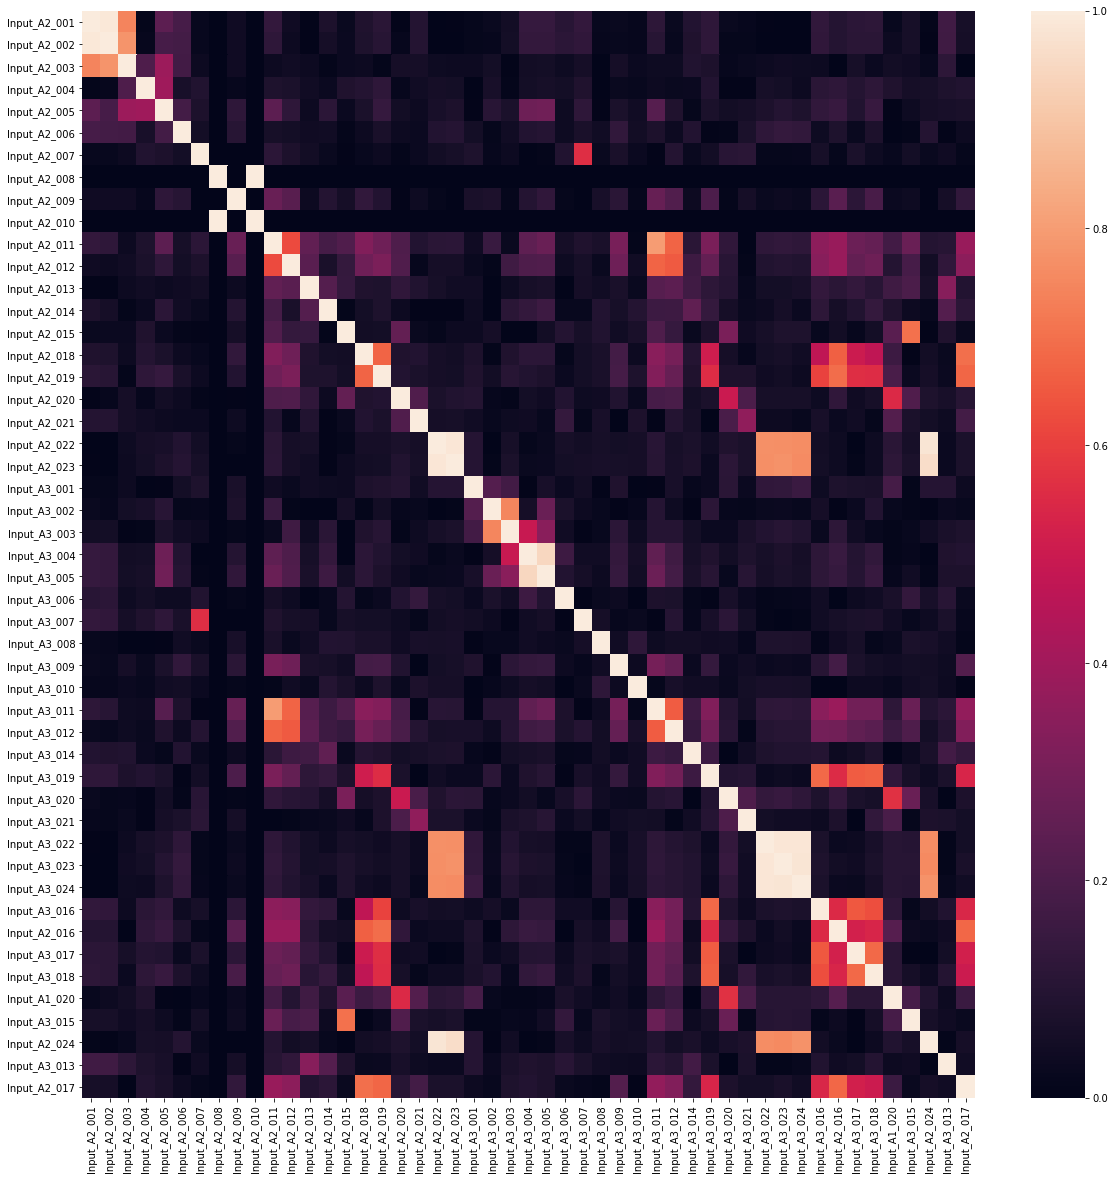

In [47]:
fig_, ax = plt.subplots(figsize=(20, 20))
test = pd.concat([train_features,train_labels], axis=1)
sns.heatmap(np.abs(test.filter(regex='(Input_A[2-3]_[0-9]+|Input_A1_020)').corr()))